## 손실함수 
- (앞은 다 아는 내용이라 넘어감 여기서도 MAE, cross_entropy_error 두개 흝어보고만 지나가면 됨)

In [17]:
import numpy as np
y2 = np.array([0.1, 0.05, 0.7, 0.05, 0.05, 0, 0, 0, 0, 0.05]) # 2일 확률이 가장 높음
y0 = np.array([0.5, 0.3, 0.1, 0.05, 0.05, 0, 0, 0, 0, 0]) # 0일 확률이 가장 높음
# 넣는건 꼭 array로!
answer = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 정답 2

def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t)**2)

In [18]:
print(mean_squared_error(y2, answer)) # 더 작으므로 정답에 가까움
print(mean_squared_error(y0, answer))

0.055000000000000014
0.5774999999999999


In [19]:
def cross_entropy_error(y, t):
    delta = 1e-10 # np.log에 0이 입력되었을때 -inf가 되기 때문에 그걸 방지하기 위해
    # 엄청나게 작은 수를 더해줌
    return -np.sum(t * np.log(y + delta)) # np.log = 자연로그

In [20]:
print(cross_entropy_error(y2, answer)) # 더 작으므로 정답에 가까움
print(cross_entropy_error(y0, answer))

0.3566749437958753
2.302585091994046


## 미니배치
- 손실함수 값은 모든 데이터를 대상으로 구해야 함 (100개면 100개, 60000개면 60000개...)
- 데이터가 수백만개가 되면 너무 비효율적임 --> 근사치를 이용
- 데이터를 100개 정도만 뽑아서 100개의 손실함수를 구하고 그것을 평균냄

In [65]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data() # 정규화와 one_hot_encoding 수행

t_train_one_hot = np.zeros((t_train.size, t_train.max()+1)) # 배열 원핫인코딩 코드
t_train_one_hot[np.arange(t_train.size),t_train] = 1

t_test_one_hot = np.zeros((t_test.size, t_test.max()+1)) # 배열 원핫인코딩 코드
t_test_one_hot[np.arange(t_test.size),t_test] = 1

# x_train = np.array(list(map(lambda n : n / 255, x_train))) # 정규화 코드
# x_test = np.array(list(map(lambda n : n / 255, x_test))) # 정규화 코드

x_train = np.array(list(map(lambda n : n.reshape(784, ), x_train))) # flatten 코드
x_test = np.array(list(map(lambda n : n.reshape(784, ), x_test))) # flatten 코드

print(x_train.shape, t_train_one_hot.shape)

(60000, 784) (60000, 10)


In [66]:
t_train = t_train_one_hot.copy()
t_test = t_test_one_hot.copy()

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

# 예시
print(np.random.choice(60000, 10))

[34769 18203 21299 40602 59822 16119 24201 31983 47725 13628]


In [67]:
def cross_entropy_error2(y, t):
    if y.dim == 1:
        t = t.reshape(1, t.size) # size는 배열안이 몇 차원이든 요소의 개수를 전부 출력함
        y = y.reshape(1, y.size) # mnist의 경우에는 784 * 60000?
        # 1차원이 이 안에 들어가면 2차원이 됨, 놀라운 발견!
        # ex) [0, 1, 2] --> [[0, 1, 2]]
        
    batch_size = y.shape[0] # 배치사이즈가 100이면 이미지가 100개라는 뜻
    # [100, 100, 100, 100] <-- 0번째니 100이 됨
    return -np.sum(t * np.log(y + 1e-10)) / batch_size # batch_size로 나누는 것은 정규화를 위한 것

In [68]:
# 근데 이 함수는 굳이 안써도 될거같음
def cross_entropy_error3(y, t): # 정답 레이블이 원핫 인코딩으로 주어지지 않았을 경우
    if y.dim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-10)) / batch_size

# np.arange를 사용하면 배치사이즈만큼의 ([0 ~ 99] <-- 이런 어레이가 만들어짐)
# 여기에 t는 정답 레이블 [2, 7, 0...]
# 따라서 y[0, 2], y[1, 7]... <-- 2차원 어레이 y의 0번째 2, y의 1번째 7...

## 정확도 대신 손실함수 (loss function)을 사용하는 이유
- 용어: 매개변수 = 가중치와 편향
- 정확도를 기준으로 사용하면 매개변수 변경으로 정확도가 개선된다 해도 34%, 35% 이런 불연속적인 값으로 변함
- 그 이유는 신경망 학습에서 매개변수의 미분 값을 단서로 매개변수를 서서히 갱신시키기 때문
- 기울기가 음수면 매개변수를 양의 방향으로 변화시켜 손실함수를 줄임
- 반대로 기울기가 양수면 매개변수를 음의 방향으로 변화시켜 손실함수를 줄임
- 미분값이 0이 되게 하는 것이 목표, 기울기가 0이 되면 매개변수 갱신이 멈춤
- 하지만 손실함수를 사용하면 0.92543, 0.93432... 이렇게 연속적으로 변화시킬 수 있음
- 계단 함수와 시그모이드 함수를 생각하면 편함

## 수치미분을 파이썬으로 구현

In [88]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D # 3차원 그래프 그리기 위해 임포트

In [77]:
# 미분값 구하기 함수
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x + h) - f(x - h)) / (2 * h)

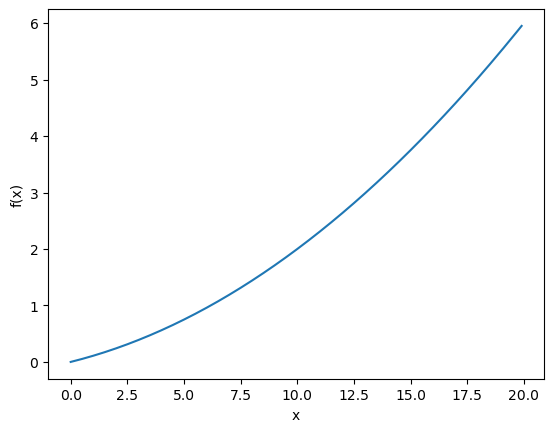

In [80]:
# 테스트용 방정식
# y = 0.01x^2 + 0.1x

def function_1(x): # 위 식을 함수화
    return 0.01*x**2 + 0.1*x

x = np.arange(0.0, 20.0, 0.1) # 0 ~ 20까지 단위는 0.1
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [83]:
print(numerical_diff(function_1, 5)) # 5에서의 미분값
print(numerical_diff(function_1, 10)) # 10에서의 미분값

0.1999999999990898
0.2999999999986347


In [85]:
def function_2(x):
    return x[0]**2 + x[1]**2 # 또는 return np.sum(x**2)

def function_2_1(x):
    return np.sum(x**2)

[[-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
  -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
  -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
   2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
   6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01]
 [-1.00000000e+00 -9.00000000e-01 -8.00000000e-01 -7.00000000e-01
  -6.00000000e-01 -5.00000000e-01 -4.00000000e-01 -3.00000000e-01
  -2.00000000e-01 -1.00000000e-01 -2.22044605e-16  1.00000000e-01
   2.00000000e-01  3.00000000e-01  4.00000000e-01  5.00000000e-01
   6.00000000e-01  7.00000000e-01  8.00000000e-01  9.00000000e-01]]
[array([2.00000000e+00, 1.62000000e+00, 1.28000000e+00, 9.80000000e-01,
       7.20000000e-01, 5.00000000e-01, 3.20000000e-01, 1.80000000e-01,
       8.00000000e-02, 2.00000000e-02, 9.86076132e-32, 2.00000000e-02,
       8.00000000e-02, 1.80000000e-01, 3.20000000e-01, 5.00000000e-01,
       7.20000000e-01, 9.80000000e-01, 1.28000000e+0

ValueError: input operand has more dimensions than allowed by the axis remapping

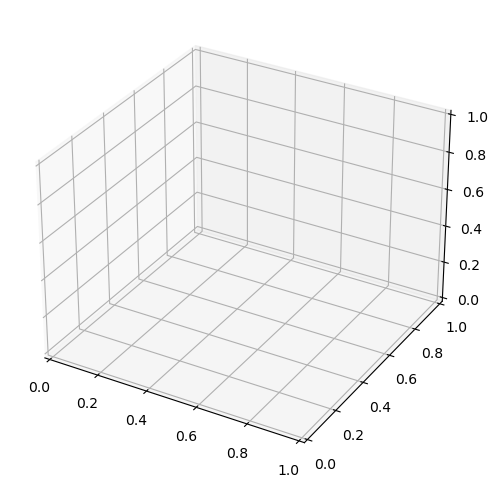

In [137]:
x1 = np.arange(-1, 1, 0.1) # 0 ~ 20까지 단위는 0.1
x2 = np.arange(-1, 1, 0.1)
x = np.array([x1, x2])
print(x)
y = np.meshgrid(function_2(x))
print(y)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, x2, y)
plt.show()